In [14]:
import yfinance as yf
import plotly.graph_objects as go
tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD']

# Загрузка данных по тикерам
data = yf.download(tickers, period='1y', interval='1h', group_by='ticker')

[*********************100%%**********************]  3 of 3 completed


In [15]:
# Добавление колонки "Range" для каждого тикера
for ticker in tickers:
    data[(ticker, 'Range')] = data[(ticker, 'High')] - data[(ticker, 'Low')]
    
    # Отображение данных по каждому тикеру
for ticker in tickers:
    print(f"Данные для {ticker}:")

    # Создание и отображение свечного графика с использованием plotly
    fig = go.Figure(data=[go.Candlestick(x=data.index,
                                         open=data[(ticker, 'Open')],
                                         high=data[(ticker, 'High')],
                                         low=data[(ticker, 'Low' )],
                                         close=data[(ticker, 'Close' )])])

    fig.update_layout(title=f'Stock Price Data for {ticker}',
                      xaxis_title='Date',
                      yaxis_title='Price (USD)',
                      xaxis_rangeslider_visible=False)
    
    fig.show()

Данные для BTC-USD:


Данные для ETH-USD:


Данные для BNB-USD:


Дальше будем работать с BTC-USD

In [51]:
from backtesting.test import EURUSD, SMA

btc_data = EURUSD.copy()
btc_data = btc_data.copy()

In [52]:
btc_data

,Open,High,Low,Close,Volume
2017-04-19 09:00:00,1.07160,1.07220,1.07083,1.07219,1413
2017-04-19 10:00:00,1.07214,1.07296,1.07214,1.07260,1241
2017-04-19 11:00:00,1.07256,1.07299,1.07170,1.07192,1025
2017-04-19 12:00:00,1.07195,1.07280,1.07195,1.07202,1460
2017-04-19 13:00:00,1.07200,1.07230,1.07045,1.07050,1554
...,...,...,...,...,...
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065


In [53]:
btc_data

,Open,High,Low,Close,Volume
2017-04-19 09:00:00,1.07160,1.07220,1.07083,1.07219,1413
2017-04-19 10:00:00,1.07214,1.07296,1.07214,1.07260,1241
2017-04-19 11:00:00,1.07256,1.07299,1.07170,1.07192,1025
2017-04-19 12:00:00,1.07195,1.07280,1.07195,1.07202,1460
2017-04-19 13:00:00,1.07200,1.07230,1.07045,1.07050,1554
...,...,...,...,...,...
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065


In [54]:
from backtesting.test import SMA
import pandas as pd 
import talib

def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data['High'] + data['Low'] + data['Close']) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std * std
    lower = mean - n_std * std
    return upper, lower

# Рассчитываем скользящие средние
close = btc_data['Close'].values
sma10 = talib.SMA(close, timeperiod=10)
sma20 = talib.SMA(close, timeperiod=20)
sma50 = talib.SMA(close, timeperiod=50)
sma100 = talib.SMA(close, timeperiod=10)

# Bollinger Bands
upper, lower = BBANDS(btc_data, 20, 2)

# Преобразование numpy массивов в серии
sma10 = pd.Series(sma10, index=btc_data.index).shift(9)  # 9, так как SMA(10) использует 10 точек, первая на 9 шагов впереди
sma20 = pd.Series(sma20, index=btc_data.index).shift(19)
sma50 = pd.Series(sma50, index=btc_data.index).shift(49)
sma100 = pd.Series(sma100, index=btc_data.index).shift(99)

# Добавление новых признаков в DataFrame
btc_data['X_SMA10'] = (close - sma10) / close
btc_data['X_SMA20'] = (close - sma20) / close
btc_data['X_SMA50'] = (close - sma50) / close
btc_data['X_SMA100'] = (close - sma100) / close

btc_data['X_DELTA_SMA10'] = (sma10 - sma20) / close
btc_data['X_DELTA_SMA20'] = (sma20 - sma50) / close
btc_data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Индикаторы
btc_data['X_MOM'] = btc_data['Close'].pct_change(periods=2)
btc_data['X_BB_upper'] = (upper - btc_data['Close']) / close
btc_data['X_BB_lower'] = (lower - btc_data['Close']) / close
btc_data['X_BB_width'] = (upper - lower) / close
# btc_data['X_Sentiment'] = ~btc_data.index.to_series().between('2017-09-27', '2017-12-14')

# Признаки даты и времени
btc_data['X_day'] = btc_data.index.dayofweek
btc_data['X_hour'] = btc_data.index.hour

# Удаляем пропуски и приводим все данные к float
btc_data = btc_data.dropna()

# Выводим результат
btc_data.tail()

,Open,High,Low,Close,Volume,X_SMA10,X_SMA20,X_SMA50,X_SMA100,X_DELTA_SMA10,X_DELTA_SMA20,X_DELTA_SMA50,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_day,X_hour
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203,-0.002821,-0.001867,-0.009770,-0.005392,0.000954,-0.007902,0.004378,-0.000040,0.004715,0.000050,0.004666,2,11
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325,-0.003420,-0.002606,-0.010418,-0.006276,0.000814,-0.007812,0.004142,0.000259,0.005591,0.000244,0.005347,2,12
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824,-0.003741,-0.003106,-0.010845,-0.006757,0.000635,-0.007740,0.004089,-0.001045,0.006103,0.000132,0.005971,2,13
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065,-0.003296,-0.002767,-0.010403,-0.006468,0.000529,-0.007635,0.003935,0.000032,0.005613,-0.000739,0.006351,2,14
2018-02-07 15:00:00,1.23427,1.23444,1.22904,1.22904,6143,-0.007756,-0.006979,-0.014619,-0.011039,0.000778,-0.007640,0.003580,-0.003793,0.010216,0.002492,0.007724,2,15


In [55]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.3988439306358382


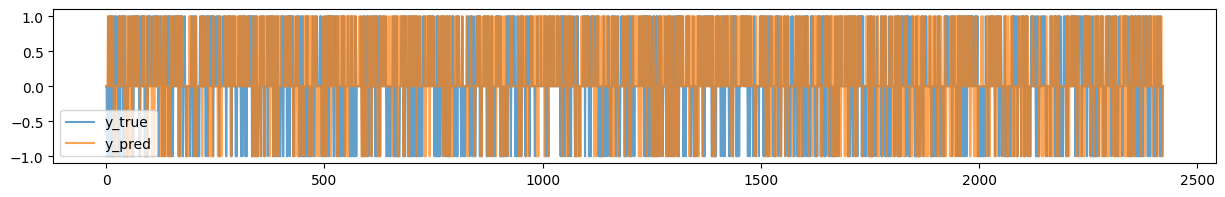

In [56]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(btc_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [59]:
%%time

from backtesting import Backtest, Strategy

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(btc_data, MLTrainOnceStrategy, cash=100000, commission=.0002, margin=0.05)
bt.run()

CPU times: total: 7.19 s
Wall time: 7.33 s


Start                     2017-04-25 21:00:00
End                       2018-02-07 15:00:00
Duration                    287 days 18:00:00
Exposure Time [%]                   76.696648
Equity Final [$]                156614.105146
Equity Peak [$]                 159810.243746
Return [%]                          56.614105
Buy & Hold Return [%]               12.464999
Return (Ann.) [%]                   58.337158
Volatility (Ann.) [%]               33.794204
Sharpe Ratio                         1.726247
Sortino Ratio                        4.104803
Calmar Ratio                         5.591556
Max. Drawdown [%]                  -10.433082
Avg. Drawdown [%]                   -1.126626
Max. Drawdown Duration       43 days 11:00:00
Avg. Drawdown Duration        2 days 14:00:00
# Trades                                  392
Win Rate [%]                         51.27551
Best Trade [%]                       0.556658
Worst Trade [%]                     -0.519427
Avg. Trade [%]                    

In [60]:
bt.plot()

Row(id='2929', ...)